In [1]:

# 🔧 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 📦 Opcional: instalar raphtory si no lo tienes
# !pip install raphtory

# 🔄 Cargar datos y preparar grafo
df = pd.read_csv("kiali_kpi_metrics.csv")
df['time_window'] = df['time_window'].astype(str).str.strip()
df = df[df['time_window'] == "15S"].copy()
df['error_rate'] = pd.to_numeric(df['error_rate'], errors='coerce').fillna(0.0)
df = df[df['istio_request_bytes'] != 0.0]
df = df[df['new_request'] >= 0.0]
df = df.dropna(subset=["request_rate"])

# 🏷️ Asignar etiqueta
def assign_status(er):
    return 0 if er < 0.15 else 1
df['status'] = df['error_rate'].apply(assign_status)
df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) / 10**9

# 🎛️ Normalizar características
features = ['throughput', 'duration_milliseconds', 'request_rate',
            'istio_request_bytes', 'average_latency', 'new_request', 'timestamp']
target = 'status'
df[features] = MinMaxScaler().fit_transform(df[features])

# 📌 Crear nodos
all_nodes = sorted(list(set(df['source_workload']).union(set(df['destination_workload']))))
node_map = {node: i for i, node in enumerate(all_nodes)}

class MicroserviceDataset:
    def __init__(self, df, node_map, features, target):
        self.df = df
        self.node_map = node_map
        self.features = features
        self.target = target
        
    def __len__(self): return 1
    
    def __getitem__(self, idx):
        edge_index = []
        edge_attr = []
        edge_labels = []

        for _, row in self.df.iterrows():
            src = self.node_map[row['source_workload']]
            tgt = self.node_map[row['destination_workload']]
            edge_index.append([src, tgt])
            edge_attr.append(row[self.features].values)
            edge_labels.append(row[self.target])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)
        x = torch.randn((len(self.node_map), 16))
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)

class EdgePredictorGNN(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.edge_predictor = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        src, dst = data.edge_index
        h_src = x[src]
        h_dst = x[dst]
        edge_emb = torch.cat([h_src, h_dst, data.edge_attr], dim=1)
        return self.edge_predictor(edge_emb)

# 🚂 Entrenamiento
dataset = MicroserviceDataset(df, node_map, features, target)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EdgePredictorGNN(node_features=16, edge_features=len(features), hidden_dim=64, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss:.4f}")

# 📊 Evaluación
model.eval()
with torch.no_grad():
    data = dataset[0].to(device)
    out = model(data)
    pred = out.argmax(dim=1).cpu().numpy()
    truth = data.y.cpu().numpy()
    print("\nClassification Report:")
    print(classification_report(truth, pred, target_names=['healthy', 'degraded']))
    print("Macro F1-score:", f1_score(truth, pred, average='macro'))


C:\Users\marti\AppData\Local\Temp\ipykernel_31876\1980424185.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)


Epoch 10 | Loss: 0.8551
Epoch 20 | Loss: 0.3283
Epoch 30 | Loss: 0.1750
Epoch 40 | Loss: 0.3411
Epoch 50 | Loss: 0.4383
Epoch 60 | Loss: 0.1251
Epoch 70 | Loss: 0.1030
Epoch 80 | Loss: 0.1019
Epoch 90 | Loss: 0.1646
Epoch 100 | Loss: 0.1136

Classification Report:
              precision    recall  f1-score   support

     healthy       0.92      1.00      0.96       357
    degraded       1.00      0.06      0.12        31

    accuracy                           0.93       388
   macro avg       0.96      0.53      0.54       388
weighted avg       0.93      0.93      0.89       388

Macro F1-score: 0.5410905828133284


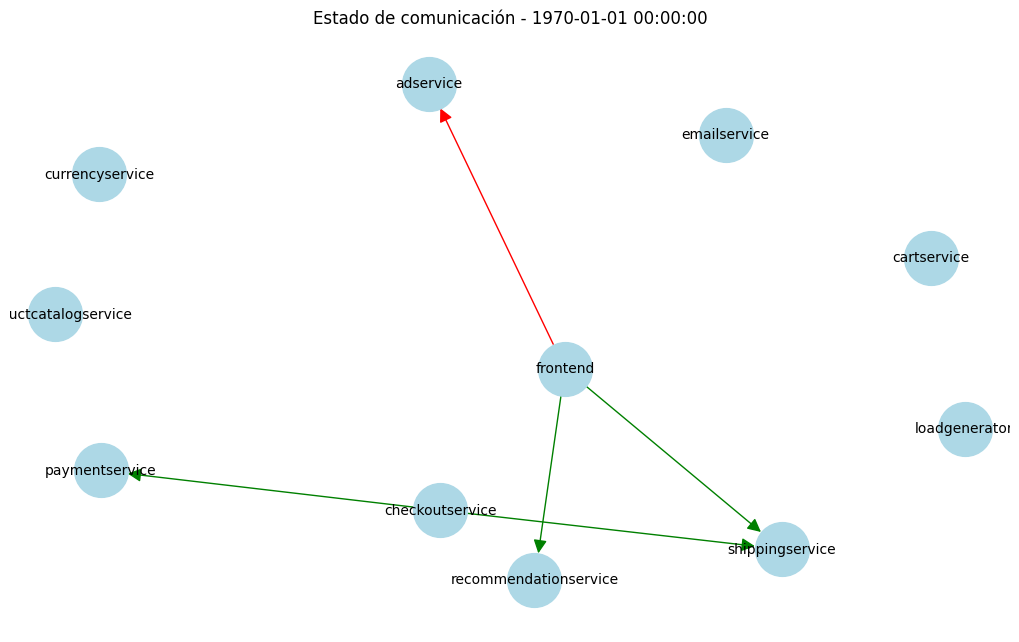

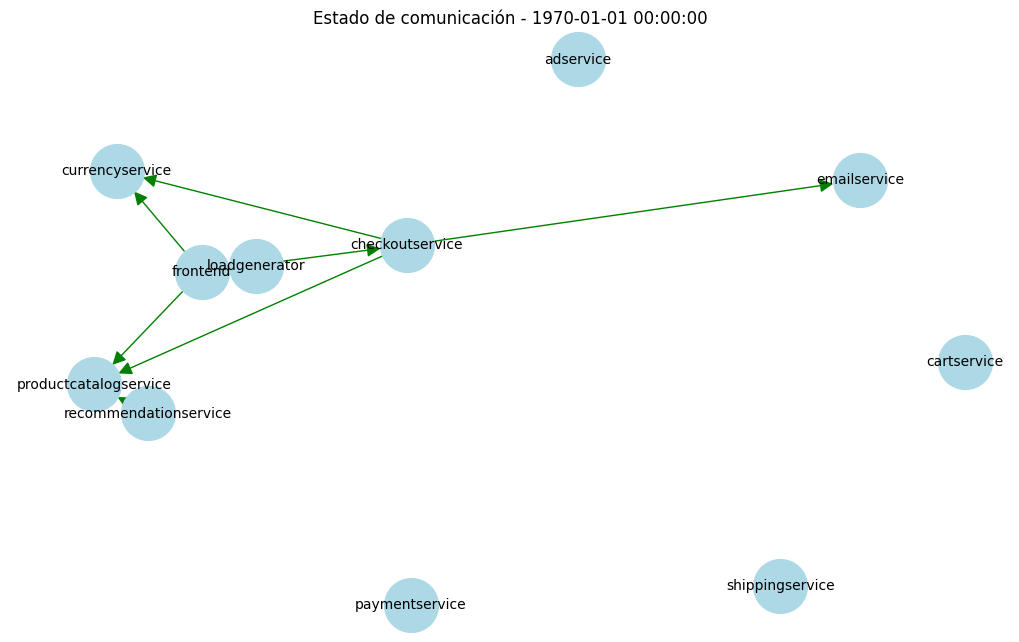

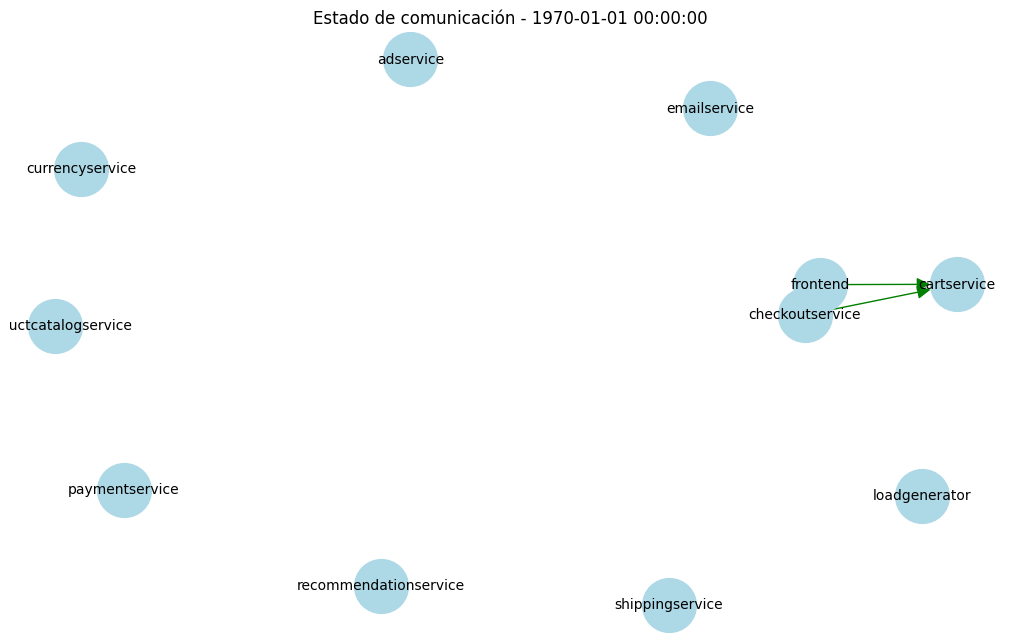

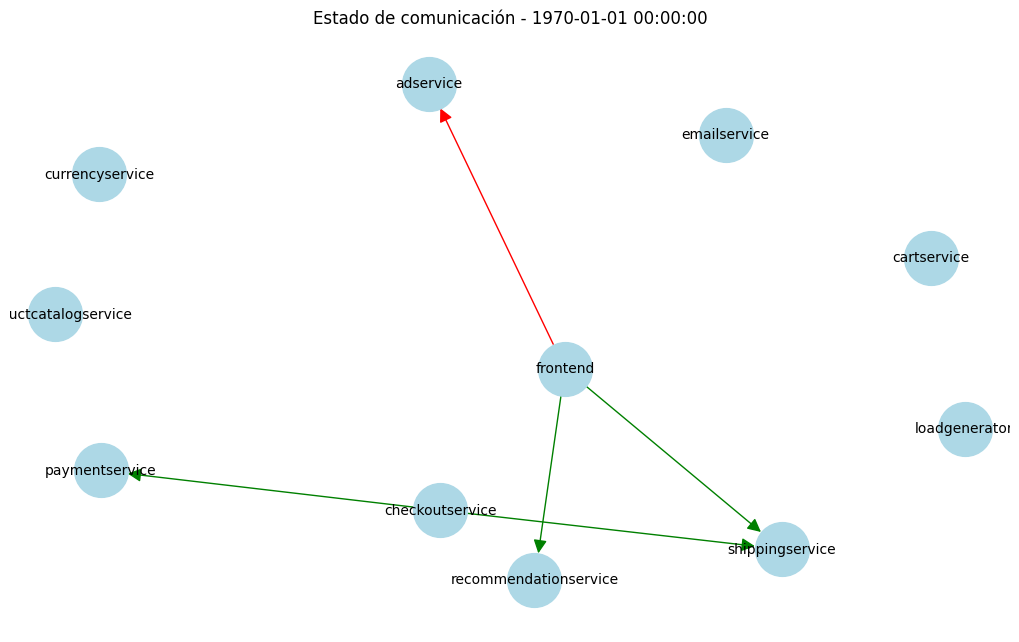

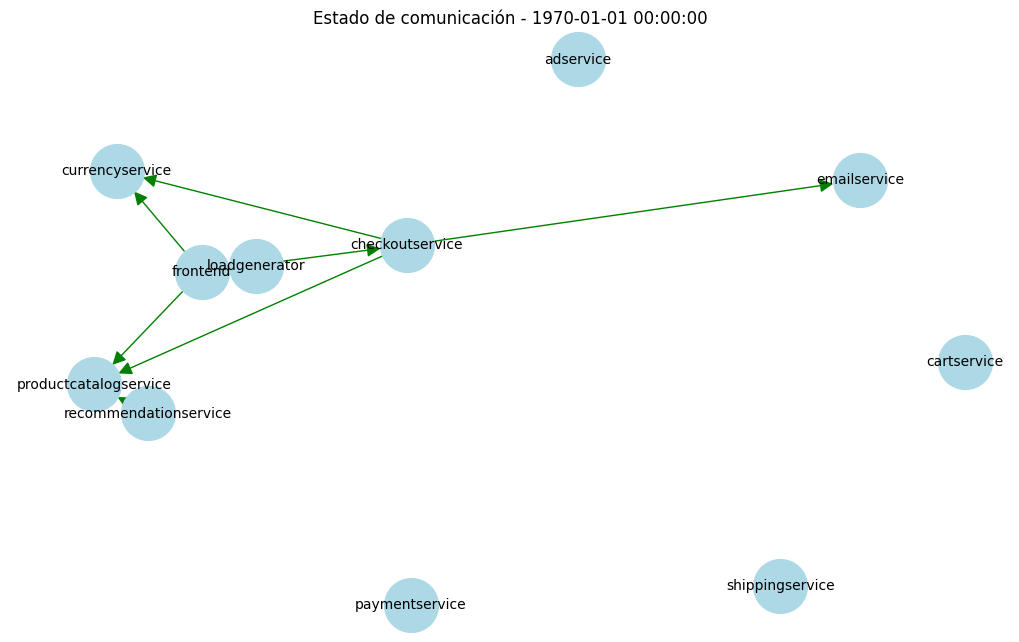

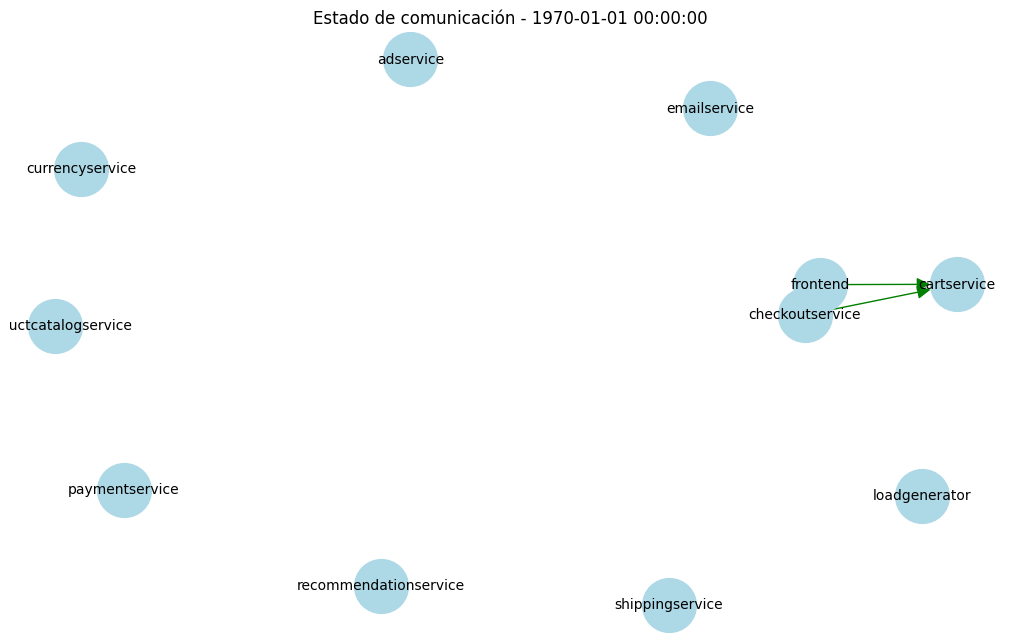

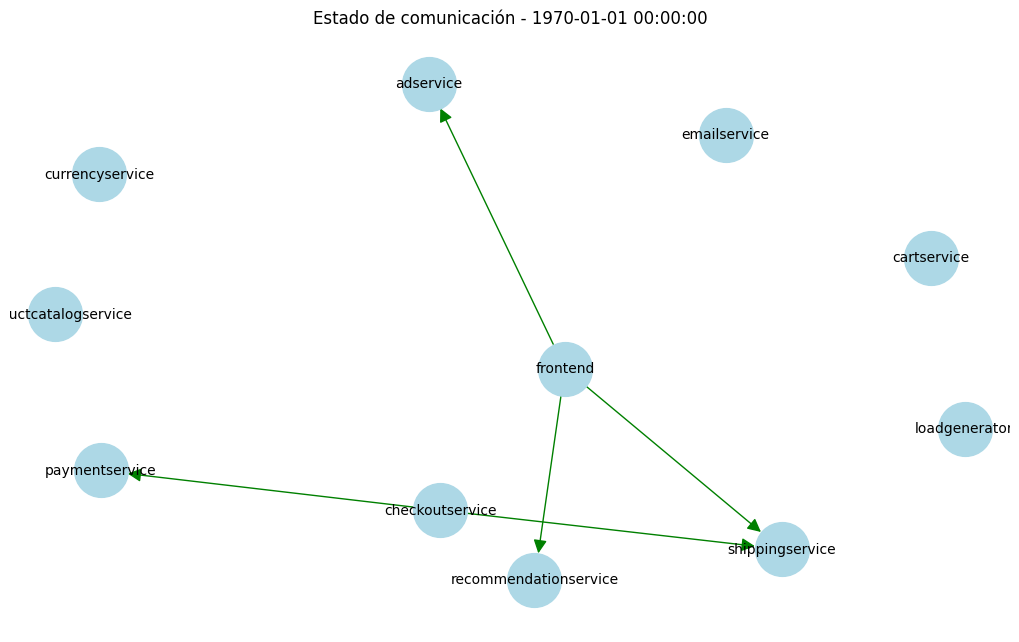

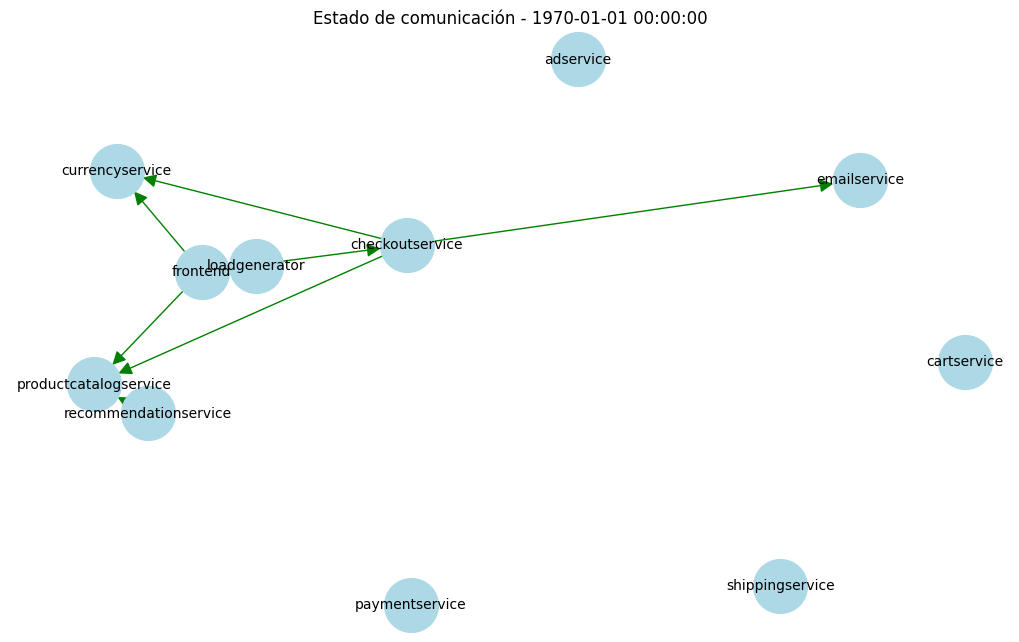

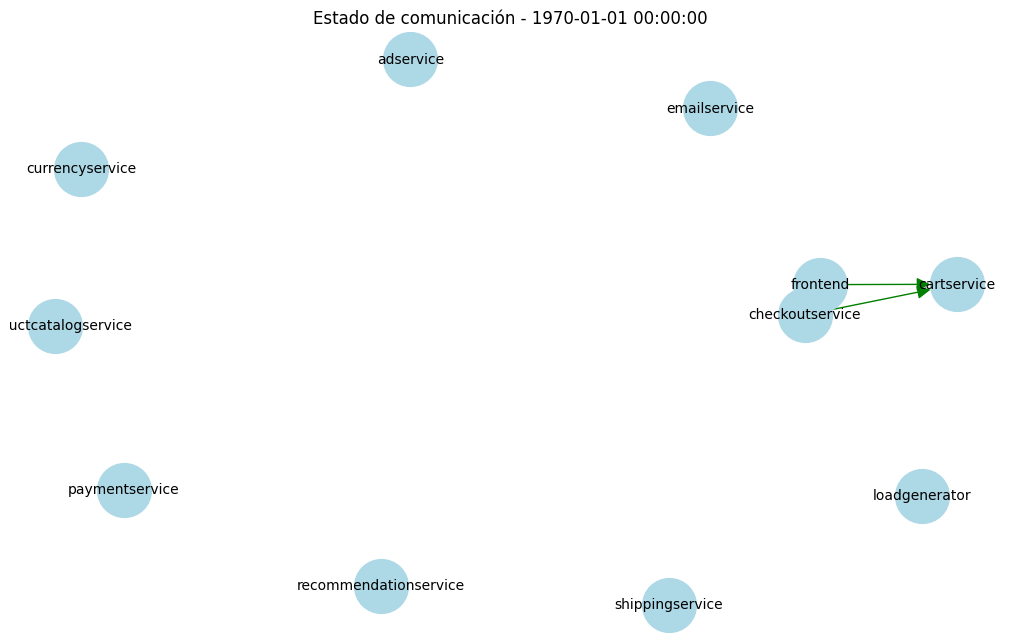

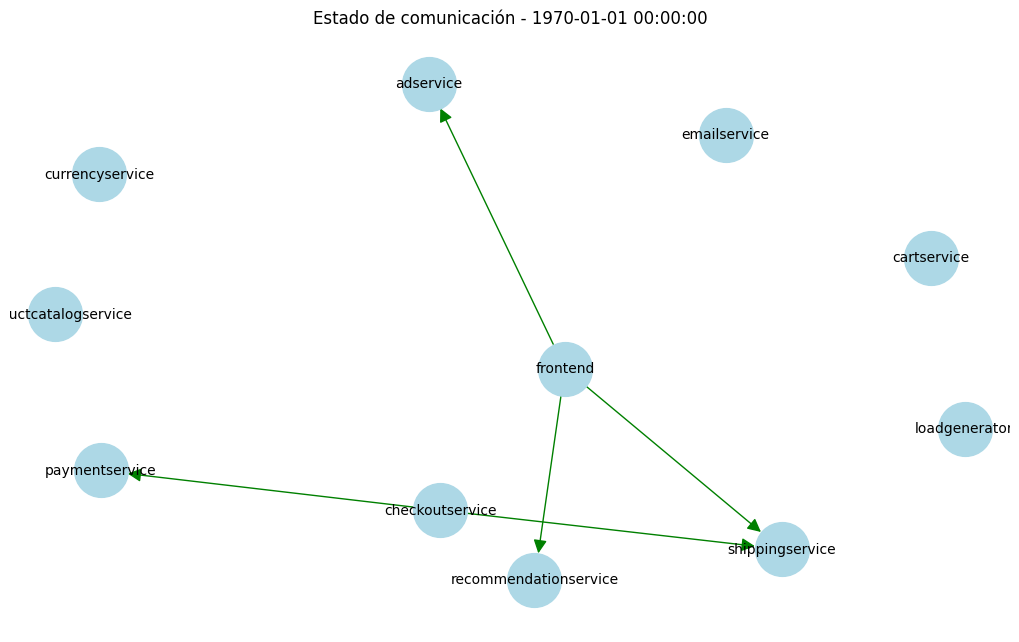

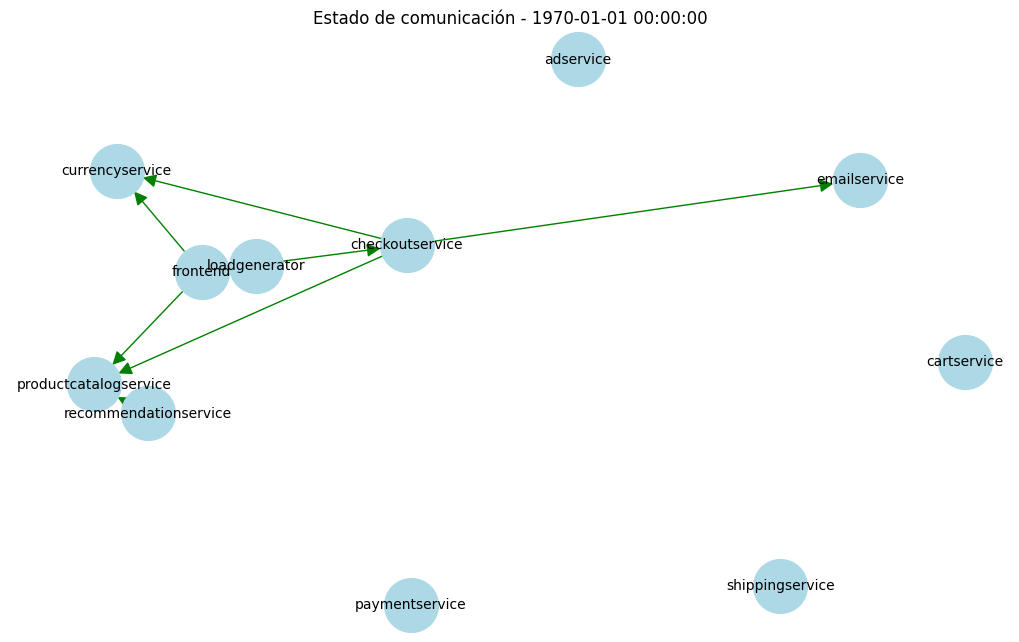

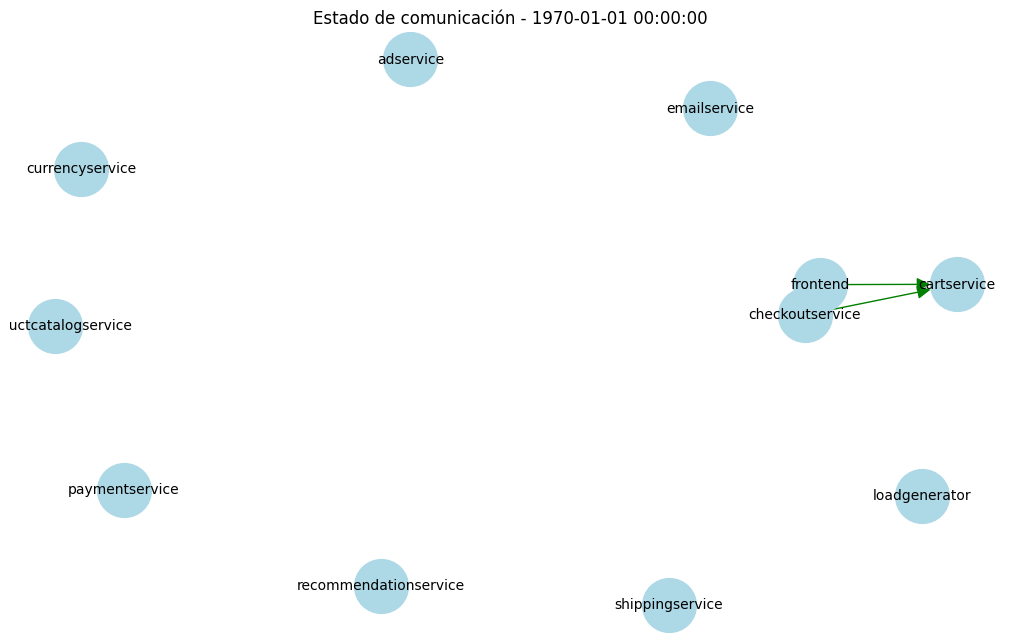

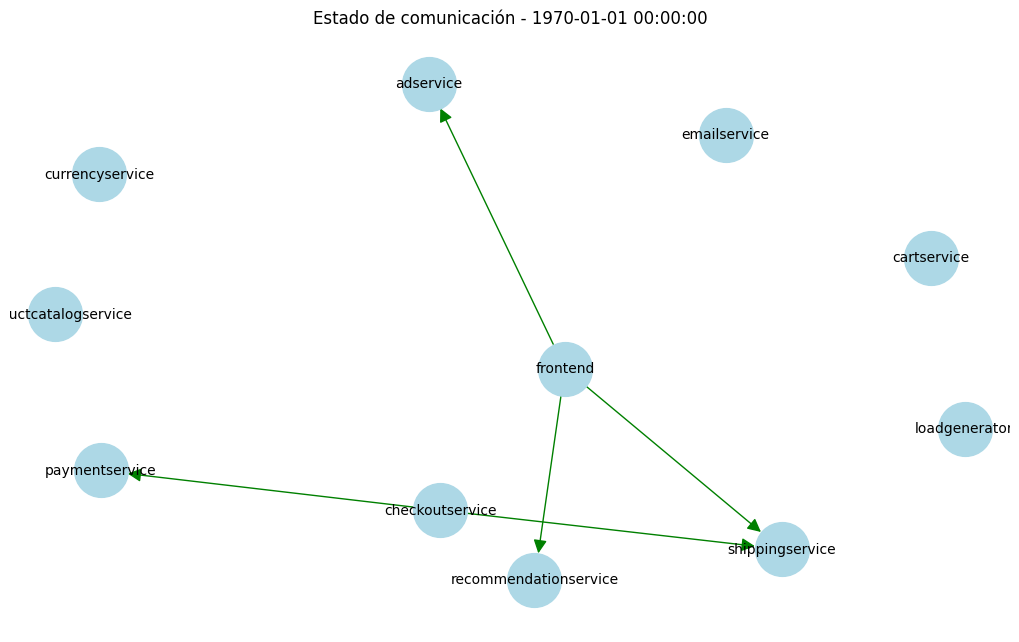

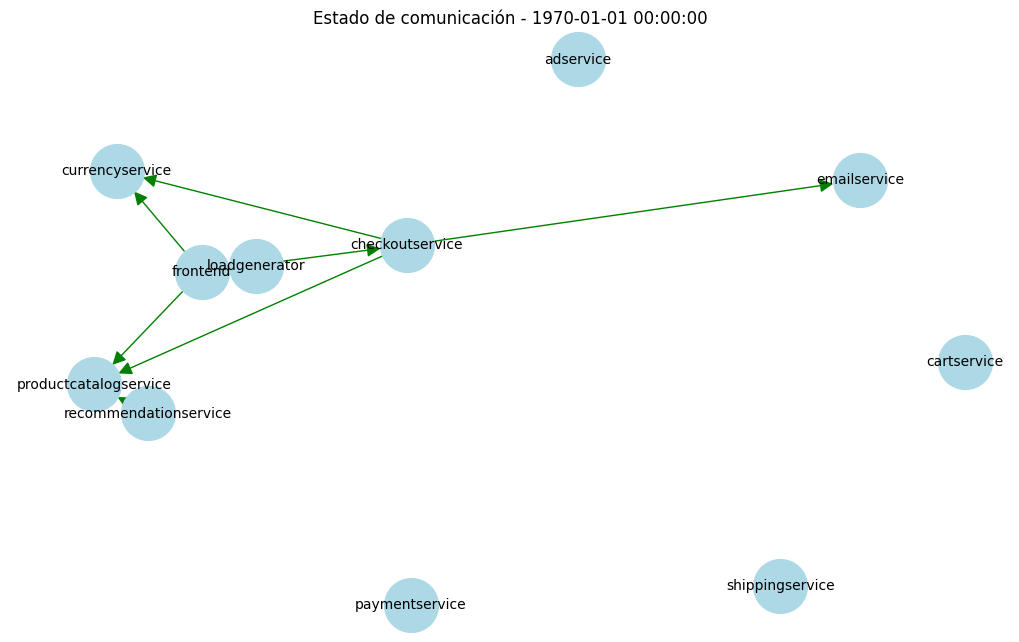

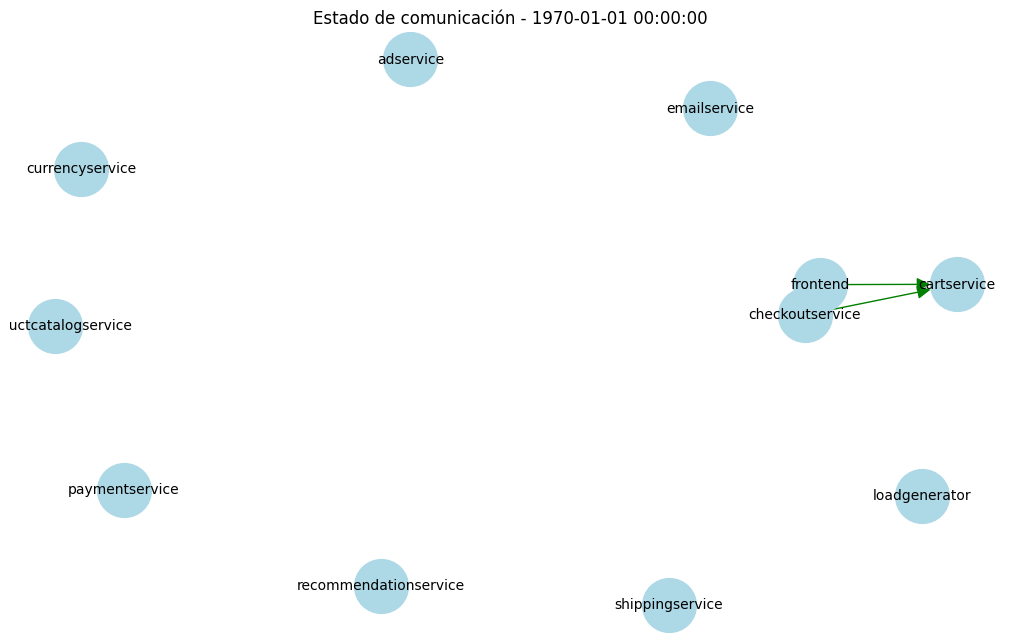

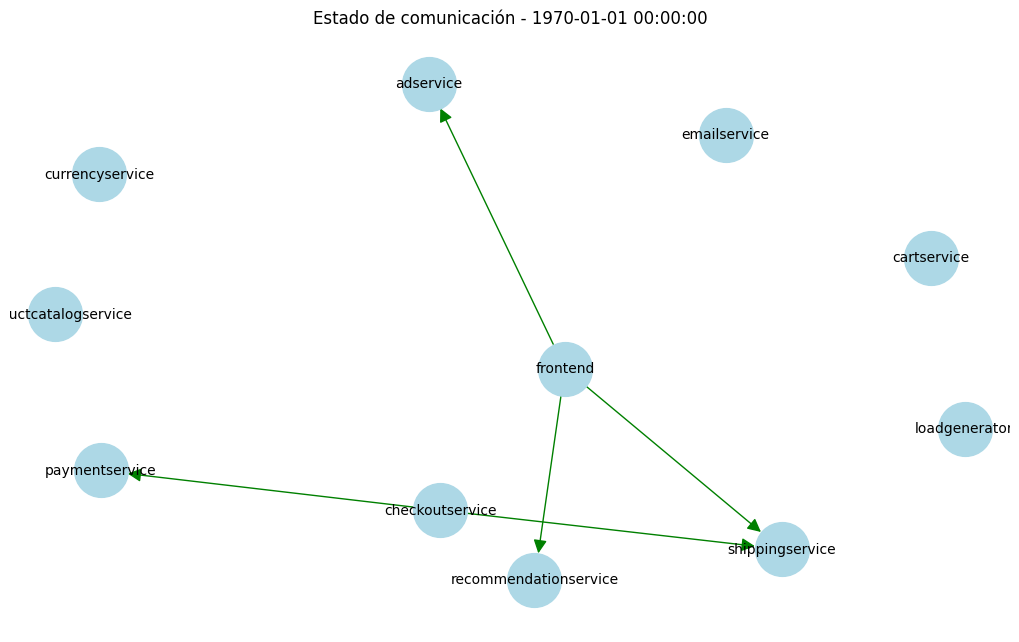

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Convertir timestamp a datetime si no está
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
timestamps = sorted(df['timestamp'].unique())

# Visualizar cada 5 momentos
step = 5
for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = df[df['timestamp'] == ts]

    G = nx.DiGraph()
    for service in node_map:
        G.add_node(service)

    for _, row in snapshot.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        status = assign_status(row["error_rate"])
        G.add_edge(src, dst, status=status)

    edge_colors = ['green' if G[u][v]['status'] == 0 else 'red' for u, v in G.edges()]

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors,
            node_size=1500, font_size=10, arrowsize=20)
    plt.title(f"Estado de comunicación - {ts.strftime('%Y-%m-%d %H:%M:%S')}")
    plt.show()
